In [1]:
cd ..

/Users/lisawink/Documents


In [2]:
# Investigating Scales < 100m

In [3]:
import geopandas as gpd
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
import calc_params
import numpy as np
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
import warnings

warnings.filterwarnings('ignore')

DataTransformerRegistry.enable('vegafusion')

In [16]:
temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']
temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

In [17]:
temp

datetime_UTC,2022-09-01 00:00:00+00:00,2022-09-01 01:00:00+00:00,2022-09-01 02:00:00+00:00,2022-09-01 03:00:00+00:00,2022-09-01 04:00:00+00:00,2022-09-01 05:00:00+00:00,2022-09-01 06:00:00+00:00,2022-09-01 07:00:00+00:00,2022-09-01 08:00:00+00:00,2022-09-01 09:00:00+00:00,...,2023-08-31 21:00:00+00:00,2023-08-31 22:00:00+00:00,2023-08-31 23:00:00+00:00,2023-09-01 00:00:00+00:00,2023-09-01 01:00:00+00:00,2023-09-01 02:00:00+00:00,2023-09-01 03:00:00+00:00,2023-09-01 04:00:00+00:00,2023-09-01 05:00:00+00:00,2023-09-01 06:00:00+00:00
station_id,,,,,,,,,,,,,,,,,,,,,
FRASHA,14.78,14.53,14.20,13.73,13.38,12.81,13.81,16.09,17.72,18.89,...,16.54,16.34,18.37,19.90,19.39,18.78,18.85,18.66,18.90,19.18
FRBETZ,16.85,15.73,15.15,14.79,14.34,13.98,14.57,16.08,17.71,18.92,...,18.88,19.17,19.88,19.64,19.18,18.59,18.65,18.09,18.60,19.17
FRBRUH,16.33,15.90,15.40,14.76,14.41,13.87,14.15,15.00,17.27,19.62,...,19.69,19.91,20.42,20.40,19.85,19.22,19.15,18.63,18.91,19.52
FRDIET,13.98,14.53,13.46,13.22,13.08,14.01,15.14,18.82,19.14,19.53,...,18.43,18.85,19.45,19.48,19.00,18.33,18.26,17.62,18.46,18.95
FRDREI,16.61,16.21,16.06,15.54,14.62,14.17,14.99,16.41,17.61,18.23,...,19.33,19.43,19.91,19.92,19.29,18.76,18.68,17.99,18.30,18.78
FREBNE,13.42,13.58,13.09,13.12,12.85,12.23,13.98,16.56,18.37,19.87,...,15.05,15.08,17.47,19.52,19.08,18.38,18.47,17.81,16.14,16.68
FREICH,13.79,13.68,13.73,13.35,12.96,12.83,13.36,15.50,17.73,18.96,...,15.88,16.57,17.11,16.63,16.39,15.76,15.29,15.40,15.59,16.20
FRFRIE,15.22,14.71,14.32,13.86,13.40,13.21,14.30,17.21,21.34,21.91,...,19.14,19.41,19.92,19.93,19.29,18.76,18.70,17.78,18.10,19.03
FRGART,15.91,15.90,15.27,15.14,14.41,13.37,17.11,18.70,19.09,20.33,...,19.25,19.43,19.94,19.91,19.29,18.73,18.61,18.23,18.71,19.23


In [6]:
hiwn = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/heat_island_winter_nights.csv')

In [9]:
radius = 50

In [12]:
vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
vars.index = vars['station_id']

In [14]:
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)

In [21]:
vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)
params = vars.columns
vars = vars.merge(temp, left_on='station_id', right_on='station_id',how='inner')

scaler = StandardScaler()
vars_scaled = scaler.fit_transform(vars)
vars = pd.DataFrame(vars_scaled, columns=vars.columns, index=vars.index)


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [28]:
def stats_multiple_times(radius, var, time):

    #vars['BuSqC_wmean'] = -vars['BuSqC_wmean']
    #vars['BuFra_3D_wmean'] = -vars['BuFra_3D_wmean']
    #vars['BuIBD'] = -vars['BuIBD']
    #vars['BuAdj'] = -vars['BuAdj']

    data = vars[[var] + list(hiwn.values.flatten())].copy().reset_index()
    data = data.melt(id_vars=[var,'station_id'], value_vars=hiwn.values.flatten(), var_name='time', value_name='temperature')
    data = data.dropna()


    # Compute Spearman correlation
    spearman_corr, p_value = spearmanr(data[var], data['temperature'])

    if len(data) < 3:
        pearson_corr = np.nan
        r_squared = np.nan
        rmse = np.nan
        cooks_d = np.nan
        y_pred = np.nan
    else:
        #Pearson and r squared
        pearson_corr, _ = pearsonr(data[var], data['temperature'])
        X = sm.add_constant(data[var])  # Add constant for regression
        model = sm.OLS(data['temperature'], X).fit()
        r_squared = model.rsquared

        # Get the predicted values (fitted values)
        y_pred = model.fittedvalues

        # Calculate the residuals (errors)
        residuals = data['temperature'] - y_pred

        # Calculate the least squares error (RSS)
        rss = np.sum(residuals ** 2)
        # Calculate the Mean Squared Error (MSE)
        mse = rss / len(data[var])
        # Calculate the Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)

        # Compute Cook's distance
        influence = model.get_influence()
        cooks_d = influence.cooks_distance[0].max()  # Max Cook's distance

    return data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred

In [29]:
stats = {}

for param in list(params.values):
    data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, param, hiwn)
    stats[param] = {'spearman_corr': spearman_corr, 'p_value': p_value, 'pearson_corr': pearson_corr, 'r_squared': r_squared, 'rmse': rmse, 'cooks_d': cooks_d, 'y_pred': y_pred}

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_83681/3679746879.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_83681/3679746879.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_83681/3679746879.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, p_value = spearmanr(data[var], data['temperature'])
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_83681/3679746879.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(data[var], data['temperature'])
/var/folders/_c/80m5cqnd3ml3s2h2

In [30]:
stats = pd.DataFrame(stats).T

In [32]:
stats

,spearman_corr,p_value,pearson_corr,r_squared,rmse,cooks_d,y_pred
BuAdj,-0.118813,0.0,-0.156146,0.024382,0.98415,0.00892,0 -0.223144 1 -0.087287 2 0.04...
BuIBD,-0.14326,0.0,-0.29003,0.084118,0.924296,0.01137,0 -0.737869 1 -0.736964 3 -0.23...
BuAre_mean,0.512473,0.0,0.610288,0.372452,0.792179,0.006092,0 -0.266302 1 0.145143 2 -0.25...
BuAre_median,0.413316,0.0,0.360013,0.129609,0.932947,0.003472,0 -0.206931 1 0.193207 2 -0.11...
BuAre_std,0.40044,0.0,0.544908,0.296925,0.835454,0.005977,0 -0.198841 1 -0.152027 2 -0.25...
...,...,...,...,...,...,...,...
BuCAR,0.172776,0.0,0.448558,0.201204,0.893754,0.005861,0 -0.200239 1 -0.208679 2 -0.42...
SVF_mean,0.232025,0.0,0.241411,0.058279,0.970423,0.006688,0 0.144656 1 -0.164860 2 0.35...
SVF_std,0.035552,0.116076,-0.034644,0.0012,0.9994,0.009763,0 0.036710 1 -0.020194 2 0.01...
SVF_median,0.227796,0.0,0.211827,0.044871,0.977307,0.006432,0 0.109784 1 -0.110882 2 0.38...


In [31]:
stats.to_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/hiwn/hiwn_stats_{radius}.csv')

In [34]:
# select stats where mutual information is higher than 
selected_stats = stats[(abs(stats['spearman_corr']) > 0.4)]

In [35]:
selected_stats

,spearman_corr,p_value,pearson_corr,r_squared,rmse,cooks_d,y_pred
BuAre_mean,0.512473,0.0,0.610288,0.372452,0.792179,0.006092,0 -0.266302 1 0.145143 2 -0.25...
BuAre_median,0.413316,0.0,0.360013,0.129609,0.932947,0.003472,0 -0.206931 1 0.193207 2 -0.11...
BuAre_std,0.40044,0.0,0.544908,0.296925,0.835454,0.005977,0 -0.198841 1 -0.152027 2 -0.25...
BuAre_max,0.400268,0.0,0.518585,0.26893,0.855026,0.005438,0 -0.154059 1 -0.077069 2 -0.19...
BuAre_per75,0.430238,0.0,0.449001,0.201602,0.893531,0.004853,0 -0.226529 1 0.158942 2 -0.29...
...,...,...,...,...,...,...,...
StrENR400_mode,0.53627,0.0,0.533079,0.284173,0.914103,0.004678,2 -0.108252 4 0.736742 5 -0.44...
StrENR400_IQR,0.457291,0.0,0.525173,0.275807,0.919429,0.003129,2 0.076475 4 0.076475 5 0.07...
StrENR400_MAD,0.457291,0.0,0.525173,0.275807,0.919429,0.003129,2 0.076475 4 0.076475 5 0.07...
StrENR400_per25,0.53627,0.0,0.535862,0.287148,0.912201,0.004674,2 -0.110407 4 0.736412 5 -0.44...


KeyError: 'Parameter'

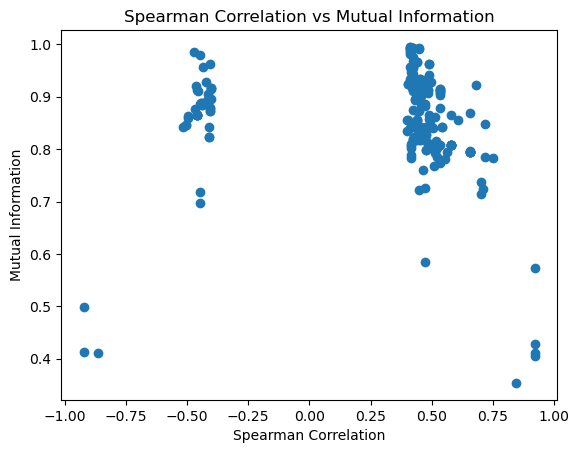

In [37]:
# plot spearman correlation and mutual information on plot for selected stats
# colour by groups

plt.scatter(selected_stats['spearman_corr'], selected_stats['rmse'])
plt.xlabel('Spearman Correlation')
plt.ylabel('Mutual Information')
plt.title('Spearman Correlation vs Mutual Information') 

for i, txt in enumerate(selected_stats['Parameter']):
    plt.annotate(txt, (selected_stats['Spearman Correlation'].iloc[i], selected_stats['Mutual Information'].iloc[i]))
    
plt.show()

In [43]:
selected_stats['Parameter'] = selected_stats.index

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_83681/3208785033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_stats['Parameter'] = selected_stats.index


In [44]:
# make interactive plot of plt.scatter(selected_stats['spearman_corr'], selected_stats['rmse'])

alt.Chart(selected_stats).mark_circle().encode(
    x='spearman_corr',
    y='rmse',
    tooltip=['Parameter']
).interactive()





alt.Chart(...)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
params_scaled = scaler.fit_transform(vars)
params_scaled = pd.DataFrame(params_scaled, columns=vars.columns, index=vars.index)
params_scaled.columns.name = 'Parameter'
# remove columns with more than 7 NaN values
#params_scaled = params_scaled.dropna(thresh=params_scaled.shape[0] - 7, axis=1)

In [38]:
vars

,BuAdj,BuIBD,BuAre_mean,BuAre_median,BuAre_std,BuAre_min,BuAre_max,BuAre_sum,BuAre_mode,BuAre_IQR,...,2023-08-31 21:00:00+00:00,2023-08-31 22:00:00+00:00,2023-08-31 23:00:00+00:00,2023-09-01 00:00:00+00:00,2023-09-01 01:00:00+00:00,2023-09-01 02:00:00+00:00,2023-09-01 03:00:00+00:00,2023-09-01 04:00:00+00:00,2023-09-01 05:00:00+00:00,2023-09-01 06:00:00+00:00
station_id,,,,,,,,,,,,,,,,,,,,,
FRASHA,1.147820,1.921324,-0.436354,-0.574789,-0.284150,-0.236059,-0.297075,-0.446406,-0.236059,-0.350912,...,-1.722942,-2.016665,-1.571129,0.214797,0.340868,0.152164,0.824564,1.083257,0.755082,0.545791
FRBETZ,0.274589,1.918094,0.237827,0.536667,-0.197926,1.709428,-0.148615,-0.465222,1.709428,-0.458226,...,0.268655,0.413263,0.519496,-0.855609,-0.818563,-0.825712,-0.168366,-0.090421,0.379988,0.533556
FRDREI,-0.598641,NaN,-0.423027,-0.321333,-0.389517,0.436907,-0.369330,-0.949590,0.436907,-0.832861,...,0.651654,0.636508,0.561031,0.297136,-0.211242,0.049229,-0.019427,-0.296329,0.004893,0.056388
FRFRIE,1.147820,0.126076,-0.148373,0.268869,-0.232004,0.088368,-0.265810,-0.838799,0.088368,-0.096886,...,0.489943,0.619335,0.574877,0.338306,-0.211242,0.049229,0.079866,-0.728737,-0.245171,0.362265
FRGART,-1.413656,-0.537915,-1.023941,-1.424290,-0.420573,-1.176407,-0.474971,-0.373736,-1.176407,-0.957990,...,0.583565,0.636508,0.602567,0.255967,-0.211242,-0.105172,-0.366952,0.197851,0.517522,0.606966
FRGLBA,0.565666,0.079501,-0.637931,-0.783132,-0.352759,-0.565342,-0.377520,-0.636136,-0.565342,-0.490495,...,-2.710229,-2.403050,-3.080255,-3.119931,-2.474893,-2.729997,-2.601045,-2.293641,-2.995867,-3.198144
FRGUNT,0.565666,-0.620698,-0.268365,0.084667,-0.288208,-0.111990,-0.264859,-0.138562,-0.111990,-0.330346,...,-1.995297,-1.656040,-0.740417,-1.678999,-1.701939,-1.237449,-1.508822,-2.478959,-2.745804,-2.892267
FRHERD,-0.016488,-0.390339,0.569703,0.936123,0.111437,0.637406,0.163177,0.238106,0.637406,0.938081,...,0.336743,0.344573,0.270282,1.244034,1.997198,2.004981,1.569261,-0.008057,-0.620266,-0.273959
FRHOLZ,0.274589,0.172434,-0.096615,0.343306,-0.214403,-0.967327,-0.180417,0.219009,-0.967327,-0.209532,...,0.226099,-0.101916,0.104140,0.173628,0.230446,-0.002238,-0.168366,0.012534,0.204943,0.264384


In [ ]:
items = params.columns.unique()

# Define mapping of abbreviations to categories
prefix_to_category = {
    'BuAre': 'Dimension', 'BuHt': 'Dimension', 'BuPer': 'Dimension',
    'BuLAL': 'Dimension', 'BuCCD': 'Dimension', 'BuCor': 'Dimension',
    'BuSA' : 'Dimension', 'BuVol': 'Dimension', 'BuSWA': 'Dimension',
    'CyAre': 'Dimension', 'CyInd': 'Dimension', 'BuCWA': 'Shape',
    'BuCon': 'Shape', 'BuElo': 'Shape', 'BuERI': 'Shape',
    'BuFR': 'Shape', 'BuFF': 'Shape', 'BuFD': 'Shape',
    'BuRec': 'Shape', 'BuShI': 'Shape', 'BuSqC': 'Shape',
    'BuSqu': 'Shape', 'BuCir': 'Shape', 'BuHem': 'Shape',
    'BuFra' : 'Shape', 'BuCubo' : 'Shape',  'BuProx' : 'Shape',
    'BuSpi' : 'Shape', 'BuPerC' : 'Shape', 'BuGir' : 'Shape',
    'BuRan' : 'Shape', 'BuAdj': 'Distribution', 'BuIBD': 'Distribution',
    'BuSWR': 'Distribution', 'BuOri': 'Orientation', 'BuAli': 'Orientation',
    'StrAli': 'Orientation', 'StrW': 'Distribution', 'StrWD': 'Distribution',
    'StrOpe': 'Distribution', 'StrHW': 'Distribution', 'StrH': 'Dimension',
    'StrHD': 'Distribution','StrLen': 'Dimension',
    'StrCNS': 'Dimension', 'BpM': 'Intensity', 'StrLin': 'Shape',
    'StrClo400': 'Connectivity', 'StrBet400': 'Connectivity', 
    'StrSCl': 'Connectivity', 'StrCyc400': 'Connectivity', 
    'StrENR400': 'Connectivity', 'StrGam400': 'Connectivity', 
    'StrDeg': 'Connectivity', 'StrMes400': 'Connectivity',
    'SVF': 'Distribution'
}

unique_prefixes = [item.split('_')[0] for item in items]

# Generate categories data dynamically
categories_data = [
    {'Category': prefix_to_category.get(prefix, 'Unknown'), 'Abbrev.': items[i]}
    for i,prefix in enumerate(unique_prefixes)
]

In [ ]:
scaled_subselect = params_scaled[selected_stats['Parameter']]
scaled_subselect[time] = params_scaled[time]

# Create the new structure
rows = []
for station_id, row in scaled_subselect.iterrows():
    y = row[time]
    for param in scaled_subselect.columns[:-1]:  # Exclude 'y'
        rows.append({
            "station_id": station_id,
            "x": row[param],
            "y": y,
            "Parameter": param
        })

# Create the transformed DataFrame
transformed_df = pd.DataFrame(rows).set_index("station_id")
categories_df = pd.DataFrame(categories_data)

In [ ]:
selected_stats = selected_stats.merge(categories_df, how='left', left_on='Parameter', right_on='Abbrev.')

In [ ]:
params =  transformed_df
params['station_id'] = params.index
selected_stats['stats'] = selected_stats['Parameter'].str.split('_').str[1]

# Left plot: R-squared vs Gradient scatter plot
selection = alt.selection_point(fields=['Parameter'], empty='none', on='click', toggle='event.shiftKey')  # Selection on param
selection1 = alt.selection_point(fields=['Category'], bind='legend', on='click', toggle='event.shiftKey')
selection2 = alt.selection_point(fields=['stats'], bind='legend', on='click', toggle='event.shiftKey')

# Step 2: Add category coloring to scatter plot
category_colors = alt.Scale(scheme='category10')  # Use a predefined Altair color scheme

scatter_plot = alt.Chart(selected_stats).mark_point(size=100).encode(
    x=alt.X('Spearman Correlation:Q', title='Spearman Correlation'),
    y=alt.Y('Mutual Information:Q', title='Mutual Information'),
    color=alt.condition(selection1, 'Category:N', alt.value('lightgray')),
    shape=alt.Shape('stats:N', title='Statistic'),
    opacity=alt.condition(selection2, alt.value(1), alt.value(0.2)),
    tooltip=['Parameter', 'Category', 'Spearman Correlation', 'Mutual Information']
).add_params(
    selection, selection1, selection2
).properties(
    title='Mutual Information vs Spearman Correlation',
    width=400,
    height=300
).interactive()

# Step 3: Right plot remains the same
points = alt.Chart(params).transform_filter(
    selection
).mark_point().encode(
    x=alt.X('x:Q', title='X'),
    y=alt.Y('y:Q', title='Temperature'),
    tooltip=['x', 'y']
)

# Create the text labels for the station IDs
text_labels = alt.Chart(params).transform_filter(
    selection
).mark_text(
    align='left', 
    baseline='middle', 
    dx=5,  # Slightly offset the text so it doesn't overlap the point
).encode(
    x='x',
    y='y',
    text='station_id'  # Use station_id as the label
)

# add drop down box for Parameter


regression_plot = (points + text_labels).properties(
    title='Linear Regression Plot',
    width=400,
    height=300
).interactive()

# Combine the plots
final_chart = alt.vconcat(scatter_plot, regression_plot)
final_chart.show()